In [159]:
import csv
import glob, os
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from pathlib import Path
from scipy import signal
from scipy.fft import fft, ifft, fftfreq, fftshift
import random
from tools import getSmoothedList, labelSwitch, standardise, getNormInfo
# from featureExtraction import getFeatureVector
from keras.models import load_model
import recognitionResults as rr
from scaling import scale

# print(y_train_class.shape)
# print(x_validate.shape)
# print(y_validate_class.shape)
# print(x_test.shape)
# print(y_test_class.shape)
# for i in range(10):
#     print(y_validate_class[i])


In [160]:
folderPath = os.path.abspath('./DataSet/newFromRealTime/sgf2503/')
filePathList=[]
data=[]
filePathList.append(glob.glob(os.path.join(folderPath, "*_log.csv")))
csvData={'lr': [] , 'rr': [], 'lw': [], 'rw': [], 'fi': []}
recordLength = 300
for filePathListIndex in filePathList:
    for f in filePathListIndex:
        fileName = Path(f).stem
        print(fileName)
        data = pd.read_csv(f, header=None).values.tolist() # csv file -> data list (data length) of list (3)
        print(len(data))
        for i in range(0,len(data),recordLength):
            sigSegment=[[],[],[]]
            for j in range(recordLength):
                sigSegment[0].append(data[i+j][0])
                sigSegment[1].append(data[i+j][1])
                sigSegment[2].append(data[i+j][2])
            # print(len(sigSegment[0]))
            # print(sigSegment[0][70:78])
            csvData[fileName[0:2]].append(sigSegment)
            # sigSegment.clear()

'''保证每个动作训练数据量一样'''
csvLength=[]
for i in csvData.keys():
    csvLength.append(len(csvData[i]))
print(csvLength)
actionLength = min(csvLength)

fi1_1_log
4500
fi1_2_log
4500
fi1_3_log
4500
fi2_1_log
4800
fi2_2_log
5100
fi2_3_log
5100
fi3_1_log
4800
fi3_2_log
5100
fi3_3_log
5400
lr1_1_log
2400
lr1_2_log
4200
lr1_3_log
6000
lr2_1_log
3900
lr2_2_log
3900
lr2_3_log
5400
lr3_1_log
3600
lr3_2_log
4800
lr3_3_log
6000
lw1_1_log
6600
lw1_2_log
6600
lw1_3_log
6600
lw2_1_log
4500
lw2_2_log
4500
lw2_3_log
5400
lw3_1_log
4500
lw3_2_log
5100
lw3_3_log
5400
rr1_1_log
4200
rr1_2_log
4800
rr1_3_log
5700
rr2_1_log
3900
rr2_2_log
4200
rr2_3_log
6600
rr3_1_log
3600
rr3_2_log
3900
rr3_3_log
4800
rw1_1_log
6000
rw1_2_log
6000
rw1_3_log
6600
rw2_1_log
5700
rw2_2_log
6000
rw2_3_log
6600
rw3_1_log
5400
rw3_2_log
6000
rw3_3_log
6600
[134, 139, 164, 183, 146]


In [161]:
# isLog = False
rawSignalMatrix=[]
labelMatrix=[]
for index in csvData.keys():
    # if isLog:
    #     featureLog = './src/'+index+'_feature.csv'
    #     fl = open(featureLog, 'w')
    # if index !='lr' or index !='rr':
        for i in range(actionLength):
            # featureVector = getFeatureVector(csvData[index][i])
            # # print(len(featureVector))
            rawSignalMatrix.append(csvData[index][i])
            labelMatrix.append(labelSwitch(index))
            # if isLog:
            #     for item in featureVector:
            #         fl.write(str(item))
            #         fl.write(',')
            #     fl.write()
            #     fl.write('\n')


rawSignalMatrix = np.array(rawSignalMatrix)
rawSignalMatrix = np.transpose(rawSignalMatrix, (0, 2, 1))
print(rawSignalMatrix.shape)
labelMatrix = np.array(labelMatrix).reshape(len(labelMatrix),1)
print(labelMatrix.shape)


(670, 300, 3)
(670, 1)


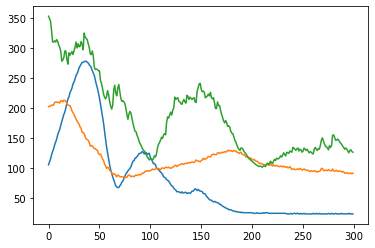

In [162]:
plt.plot(np.array(csvData['rr'][100]).T)


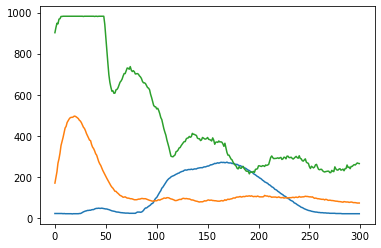

In [163]:
plt.plot(np.array(csvData['lr'][100]).T)


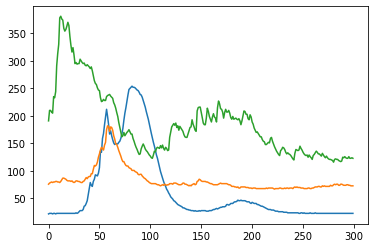

In [164]:
plt.plot(np.array(csvData['rw'][100]).T)

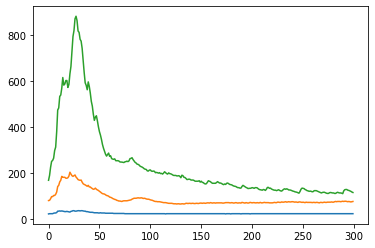

In [165]:
plt.plot(np.array(csvData['lw'][100]).T)


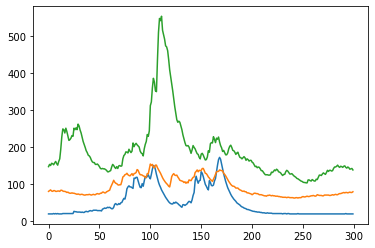

In [166]:
plt.plot(np.array(csvData['fi'][20]).T)

In [167]:
# standardise the training and test data
mu = np.mean(rawSignalMatrix, axis=(0, 1, 2))
s = np.std(rawSignalMatrix, axis=(0, 1, 2))
rawSignalMatrix = (rawSignalMatrix - mu) / s
print(mu, s)

139.7530265339967 148.2613775972213


In [168]:
# save the standardisation data
f = open('standardisation.txt','w')
f.write(str(mu))
f.write('\n')
f.write(str(s))
f.close()

In [169]:
# training the classifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv1D, BatchNormalization
from keras.utils import np_utils,normalize
from keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(1234)

In [170]:
# save mean and std into a csv for real-time standardisation
# meanValue=list(meanValue)
# stdValue=list(stdValue)
# print(len(meanValue))
# for i in range(len(meanValue)-1):
#     fileName_info.write(str(meanValue[i]))
#     fileName_info.write(',')
# fileName_info.write(str(meanValue[i+1]))
# fileName_info.write('\n')
# for i in range(len(stdValue)-1):
#     fileName_info.write(str(stdValue[i]))
#     fileName_info.write(',')
# fileName_info.write(str(stdValue[i+1]))
# fileName_info.close()

In [171]:
state = np.random.get_state()
np.random.shuffle(rawSignalMatrix)
np.random.set_state(state)
np.random.shuffle(labelMatrix)


TRAIN_SPLIT = int(0.6*rawSignalMatrix.shape[0])
TEST_SPLIT = int(0.2*rawSignalMatrix.shape[0] + TRAIN_SPLIT)

x_train, x_test, x_validate = np.split(rawSignalMatrix, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(labelMatrix, [TRAIN_SPLIT, TEST_SPLIT])

y_train_class = np_utils.to_categorical(y_train)
y_test_class = np_utils.to_categorical(y_test)
y_validate_class = np_utils.to_categorical(y_validate)

print(x_train[0].shape)

(300, 3)


In [172]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.layers import *


def model_cnn(layers_num, filters, kernel_size, activation, xShape):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                     activation=activation, input_shape=xShape))

    for _ in range(layers_num):
        model.add(Conv1D(filters=filters,
                         kernel_size=kernel_size, activation=activation))
        model.add(Dropout(0.1))

    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size, activation=activation))
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(5, activation='softmax'))

    return model

In [173]:
model = model_cnn(1, 5, 10, 'relu', x_train.shape[1:])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [174]:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='max', baseline=None, restore_best_weights=True)
history=model.fit(x_train, y_train_class, epochs=20, batch_size=25, verbose=1, validation_data=(x_validate, y_validate_class), callbacks=[early_stop])
score = model.evaluate(x_test, y_test_class, verbose=0)

Epoch 1/20
17/17 [==============================] - 0s 21ms/step - loss: 1.5285 - accuracy: 0.2537 - val_loss: 1.3605 - val_accuracy: 0.3433
Epoch 2/20
17/17 [==============================] - 0s 10ms/step - loss: 1.2925 - accuracy: 0.3856 - val_loss: 1.2339 - val_accuracy: 0.4776
Epoch 3/20
17/17 [==============================] - 0s 12ms/step - loss: 1.0734 - accuracy: 0.5920 - val_loss: 1.0631 - val_accuracy: 0.6791
Epoch 4/20
17/17 [==============================] - 0s 10ms/step - loss: 0.8979 - accuracy: 0.6940 - val_loss: 0.8984 - val_accuracy: 0.7313
Epoch 5/20
17/17 [==============================] - 0s 9ms/step - loss: 0.7757 - accuracy: 0.7214 - val_loss: 0.7613 - val_accuracy: 0.7612
Epoch 6/20
17/17 [==============================] - 0s 9ms/step - loss: 0.6876 - accuracy: 0.7687 - val_loss: 0.7205 - val_accuracy: 0.7687
Epoch 7/20
17/17 [==============================] - 0s 11ms/step - loss: 0.6357 - accuracy: 0.7786 - val_loss: 0.6538 - val_accuracy: 0.7612
Epoch 8/20
17/1

Test loss: 0.617234468460083
Test accuracy: 0.8432835936546326


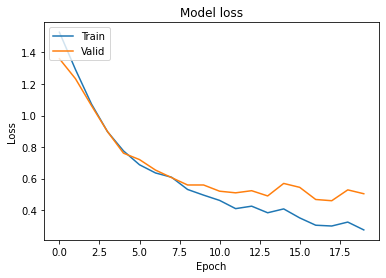

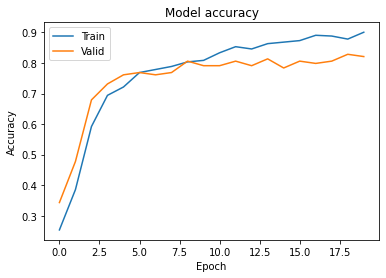

In [175]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# model.save('test3.h5')

In [176]:
model.summary()
model.save('cnnsgf.h5')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 291, 5)            155       
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 282, 5)            255       
_________________________________________________________________
dropout_16 (Dropout)         (None, 282, 5)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 273, 5)            255       
_________________________________________________________________
flatten_8 (Flatten)          (None, 1365)              0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 1365)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                